In [4]:
import os
import tensorflow as tf

### Data Preprocessing

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# Define our example directories and files
base_dir = './data/cats_and_dogs_filtered/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

In [8]:
train_cats_dir = os.path.join(train_dir, 'cats')
validation_cats_dir = os.path.join(validation_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Filenames
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [9]:
# Adds data-augmentation parameters to the ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data shouldn't be augmented
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [10]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Model Loading

In [12]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [13]:
# Pre-trained model weights
local_weights_file = './models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Defines pre-trained model
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Loads pre-trained model weights
pre_trained_model.load_weights(local_weights_file)

In [14]:
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


### Model Definition

In [15]:
from tensorflow.keras.optimizers import RMSprop

In [19]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, 
                 activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1,
                 activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

In [20]:
# Compiles the model
model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [21]:
# Fits the model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    epochs = 20,
    validation_steps = 50,
    verbose = 2)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

### Model Evaluation

In [22]:
import matplotlib.pyplot as plt

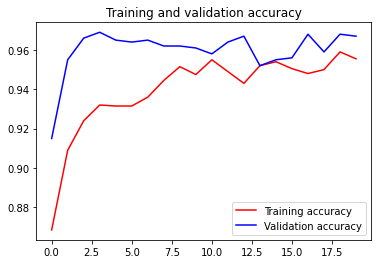

<Figure size 432x288 with 0 Axes>

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()